## Import Necessary Modules

In [1]:
#env.close()

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
import ddpg_agent
from ddpg_agent import * #Agent, normnp, scalenp, SEED, BUFFER_SIZE, BATCH_SIZE, devicez
print("Using device:", device)
%matplotlib inline

Using device: cuda:0


## Unity Reacher Environment

## Examine the State and Action Spaces

In [4]:
env = UnityEnvironment(file_name='../data/Reacher1_Win/Reacher.exe', worker_id=111, seed=SEED, no_graphics=True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
#print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33


## DDPG

#### Intialize the Agent

In [8]:
agent = Agent(  state_size=state_size, 
                action_size=action_size, 
                random_seed=SEED,
                actor_units_in=512,
                actor_units_hid=128,
                critic_units_in=512,
                critic_units_hid=128)#,
                #actor_filename='../ddpg/checkpoints/actor_training_chkpnt10.pth', critic_filename='../ddpg/checkpoints/critic_training_chkpnt10.pth')

#### Random Agent Play

In [9]:
if True:
    env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
    rap_states = env_info.vector_observations                  # get the current state (for each agent)
    rap_scores = 0                                                # initialize the score (for each agent)
    while True:
        rap_actions = agent.act(rap_states, add_noise=False)
        env_info = env.step(rap_actions)[brain_name]           # send all actions to tne environment
        rap_next_states = env_info.vector_observations         # get next state (for each agent)
        rap_rewards = env_info.rewards                         # get reward (for each agent)
        rap_dones = env_info.local_done                        # see if episode finished
        rap_scores += env_info.rewards[0]                         # update the score (for each agent)
        rap_states = rap_next_states                               # roll over states to next time step
        if np.any(rap_dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(rap_scores)))

Total score (averaged over agents) this episode: 14.159999683499336


#### Train

In [10]:
def ddpg(n_episodes=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in (range(1, n_episodes+1)):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = 0.; alss = 0.; clss = 0.
        while True:
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state, action, reward, next_state, done)
            clss, alss = agent.return_losses()
            state = next_state
            score += np.mean(reward)
            if np.any(done):
                break 
        critloss.append(clss)
        actloss.append(alss)
        scores_deque.append(score)
        scores.append(score)
        cycle_steps = agent.steps%ddpg_agent.BUFFER_SIZE
        buffer_cycle = agent.steps//ddpg_agent.BUFFER_SIZE
       
        print('\rEpisode{:5d}\tReward: {:6.2f}\tAvg. Reward: {:6.2f}\tALoss: {:8.4f}\tCLoss: {:9.4f}\tBuffer Cycle: {:3d} mod {:7d}'.format(
                i_episode, 
                score, 
                np.mean(scores_deque),
                critloss,
                actloss,
                buffer_cycle,
                cycle_steps), end="")
        
        if i_episode % 10 == 0:
            chkpntname = "checkpoints/actor_training_chkpnt{:d}.pth".format(i_episode)
            torch.save(agent.actor_local.state_dict(), chkpntname)  
            chkpntname = "checkpoints/critic_training_chkpnt{:d}.pth".format(i_episode)
            torch.save(agent.critic_local.state_dict(), chkpntname) 
            print('\rEpisode{:5d}\tReward: {:6.2f}\tAvg Reward: {:6.2f}\tAvg ALoss: {:8.4f}\tAvg CLoss: {:9.4f}\tBuffer Cycle: {:3d} mod {:7d}'.format(
                    i_episode,
                    score,
                    np.mean(scores_deque),
                    np.mean(critloss),
                    np.mean(actloss),
                    buffer_cycle,
                    cycle_steps))
            
        if np.mean(scores_deque)>=30:
            print('\n*** Avg. score above metric for 100 episodes! ***\nEnvironment officially solved at episode {:d}!\tAverage Reward: {:6.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoints/slvdpnt_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoints/slvdpnt_critic.pth')
            break

    torch.save(agent.actor_local.state_dict(), "checkpoints/actor_trained.pth")
    torch.save(agent.critic_local.state_dict(), "checkpoints/critic_trained.pth") 
    print('\nFINAL\nEpisode{:5d}\tReward: {:6.2f}\tAverage Reward: {:6.2f}\tBuffer Cycle: {:3d} mod {:7d}'.format(i_episode,score, np.mean(scores_deque), buffer_cycle, cycle_steps))
    
    return scores, critloss, actloss

In [11]:
### TRAIN AGENTS
sc, cl, al = ddpg()
try:
    scores+=sc
    critloss+=cl
    actloss+=al
except:
    scores=sc
    critloss=cl
    actloss=al

Episode   10	Reward:  18.31	Avg Reward:  11.58	Avg A Loss:   0.3555	Avg C Loss: -488.7237	Buffer Cycle:   0 mod   10010
Episode   20	Reward:  18.31	Avg Reward:  15.20	Avg A Loss:   1.1071	Avg C Loss: -849.2650	Buffer Cycle:   0 mod   20020
Episode   30	Reward:  18.72	Avg Reward:  18.57	Avg A Loss:   2.1521	Avg C Loss: -1269.5325	Buffer Cycle:   1 mod    4430
Episode   40	Reward:  18.34	Avg Reward:  20.43	Avg A Loss:   3.1837	Avg C Loss: -1691.6678	Buffer Cycle:   1 mod   14440
Episode   50	Reward:  28.93	Avg Reward:  21.80	Avg A Loss:   4.4944	Avg C Loss: -2086.0510	Buffer Cycle:   1 mod   24450
Episode   60	Reward:  29.34	Avg Reward:  22.53	Avg A Loss:   5.3544	Avg C Loss: -2472.2307	Buffer Cycle:   2 mod    8860
Episode   70	Reward:  29.09	Avg Reward:  23.53	Avg A Loss:   7.1553	Avg C Loss: -2861.0432	Buffer Cycle:   2 mod   18870
Episode   80	Reward:  20.96	Avg Reward:  23.28	Avg A Loss:   8.2241	Avg C Loss: -3160.2463	Buffer Cycle:   3 mod    3280
Episode   90	Reward:  25.28	Avg Re



Eps   10	Reward:    15.95	Avg Reward:    24.20	 Avg Eps Time: 10.485 sec	Buffer Cycle:   0 mod   10010
Eps   20	Reward:    22.38	Avg Reward:    21.96	 Avg Eps Time: 10.786 sec	Buffer Cycle:   0 mod   20020
Eps   30	Reward:    18.91	Avg Reward:    21.33	 Avg Eps Time: 10.768 sec	Buffer Cycle:   0 mod   30030
Eps   40	Reward:    27.72	Avg Reward:    22.27	 Avg Eps Time: 10.752 sec	Buffer Cycle:   0 mod   40040
Eps   50	Reward:    28.59	Avg Reward:    22.33	 Avg Eps Time: 10.750 sec	Buffer Cycle:   0 mod   50050
Eps   60	Reward:    20.83	Avg Reward:    21.82	 Avg Eps Time: 10.794 sec	Buffer Cycle:   0 mod   60060
Eps   70	Reward:    20.66	Avg Reward:    21.67	 Avg Eps Time: 10.781 sec	Buffer Cycle:   0 mod   70070
Eps   80	Reward:    30.70	Avg Reward:    22.39	 Avg Eps Time: 10.777 sec	Buffer Cycle:   0 mod   80080
Eps   90	Reward:    26.80	Avg Reward:    22.80	 Avg Eps Time: 10.781 sec	Buffer Cycle:   0 mod   90090
Eps  100	Reward:    17.80	Avg Reward:    22.86	 Avg Eps Time: 10.789 sec	Buffer Cycle:   0 mod  100100
Eps  110	Reward:    23.14	Avg Reward:    22.99	 Avg Eps Time: 10.840 sec	Buffer Cycle:   0 mod  110110
Eps  120	Reward:    27.44	Avg Reward:    23.50	 Avg Eps Time: 10.841 sec	Buffer Cycle:   0 mod  120120
Eps  130	Reward:    17.93	Avg Reward:    23.65	 Avg Eps Time: 10.844 sec	Buffer Cycle:   0 mod  130130
Eps  140	Reward:    16.29	Avg Reward:    23.19	 Avg Eps Time: 10.869 sec	Buffer Cycle:   0 mod  140140
Eps  150	Reward:    19.08	Avg Reward:    22.79	 Avg Eps Time: 10.874 sec	Buffer Cycle:   0 mod  150150
Eps  160	Reward:    26.10	Avg Reward:    23.10	 Avg Eps Time: 10.883 sec	Buffer Cycle:   0 mod  160160
Eps  170	Reward:    29.94	Avg Reward:    23.26	 Avg Eps Time: 10.891 sec	Buffer Cycle:   0 mod  170170
Eps  180	Reward:    18.89	Avg Reward:    22.73	 Avg Eps Time: 10.899 sec	Buffer Cycle:   0 mod  180180
Eps  190	Reward:    26.30	Avg Reward:    22.30	 Avg Eps Time: 10.908 sec	Buffer Cycle:   0 mod  190190
Eps  200	Reward:    33.29	Avg Reward:    22.80	 Avg Eps Time: 10.942 sec	Buffer Cycle:   0 mod  200200
Eps  210	Reward:    28.95	Avg Reward:    22.81	 Avg Eps Time: 10.951 sec	Buffer Cycle:   0 mod  210210
Eps  220	Reward:    33.37	Avg Reward:    22.99	 Avg Eps Time: 10.975 sec	Buffer Cycle:   0 mod  220220
Eps  230	Reward:    22.64	Avg Reward:    23.86	 Avg Eps Time: 10.983 sec	Buffer Cycle:   0 mod  230230
Eps  240	Reward:    31.39	Avg Reward:    25.10	 Avg Eps Time: 10.998 sec	Buffer Cycle:   0 mod  240240
Eps  250	Reward:    32.45	Avg Reward:    26.21	 Avg Eps Time: 11.007 sec	Buffer Cycle:   0 mod  250250
Eps  260	Reward:    23.49	Avg Reward:    26.93	 Avg Eps Time: 11.019 sec	Buffer Cycle:   0 mod  260260
Eps  270	Reward:    21.00	Avg Reward:    27.56	 Avg Eps Time: 11.030 sec	Buffer Cycle:   0 mod  270270
Eps  280	Reward:    30.22	Avg Reward:    28.44	 Avg Eps Time: 11.050 sec	Buffer Cycle:   0 mod  280280
Eps  290	Reward:    31.85	Avg Reward:    29.35	 Avg Eps Time: 11.070 sec	Buffer Cycle:   0 mod  290290
Eps  300	Reward:    34.63	Avg Reward:    29.40	 Avg Eps Time: 11.088 sec	Buffer Cycle:   0 mod  300300
Eps  309	Reward:    36.09	Avg Reward:    30.10	Eps Time: 11.354 sec	Buffer Cycle:   0 mod  309309
Score averaged over 100 episodes and 1 Agent stably above metric of 30.
Environment officially solved at episode 209!	Average Reward:  30.10

In [ ]:
scalenp = lambda x: (x - np.min(x))/(np.max(x) - np.min(x))
normnp = lambda x: 0. if np.std(x)==0 else (x - np.mean(x))/np.std(x) 

np.mean([el[1] for el in normnp(actloss)]), np.mean([el[0] for el in scalenp(critloss)])# = agent.return_loss()

In [ ]:
torch.save(agent.actor_local.state_dict(), 'checkpoints/trained_actor.pth')
torch.save(agent.critic_local.state_dict(), 'checkpoints/trained_critic.pth')

#### Results

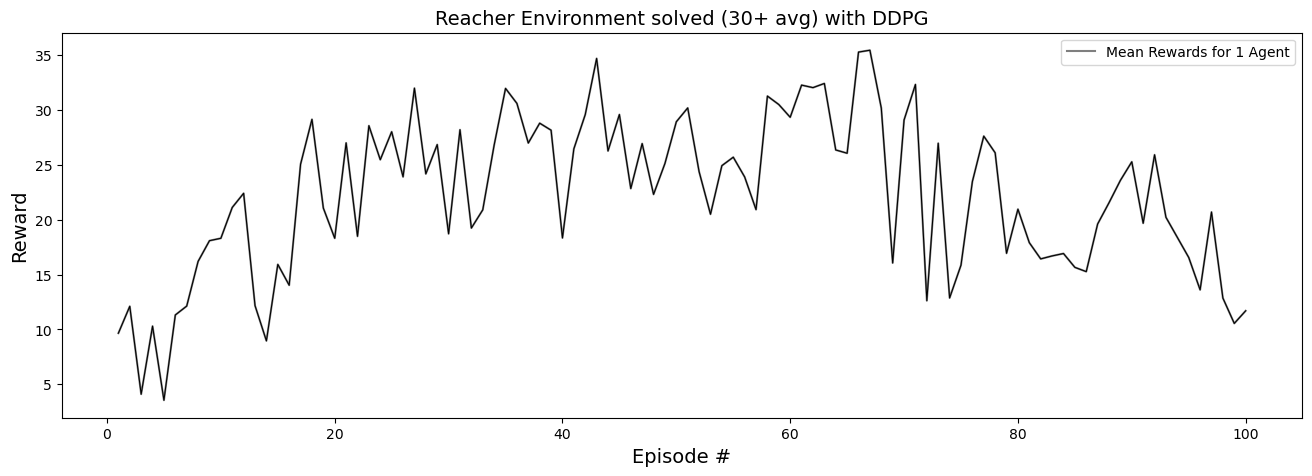

In [15]:
## Learning Curve
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(np.arange(1, len(scores)+1), scores, c='#000', alpha=0.5, linewidth=1.5, label='Mean Rewards for 1 Agent')
#for i in range(1,20):
#    ax.plot(np.arange(1, len(agent_scores)+1), [s[i] for s in agent_scores], alpha=0.5, linewidth=0.8)
ax.plot(np.arange(1, len(scores)+1), scores, c='#000', alpha=1.0, linewidth=0.75)
plt.legend()
ax.set_xlabel('Episode #', fontsize=14)
ax.set_ylabel('Reward', fontsize=14)
ax.set_title('Reacher Environment solved (30+ avg) with DDPG', fontsize=14)
plt.show()

TypeError: object of type 'float' has no len()

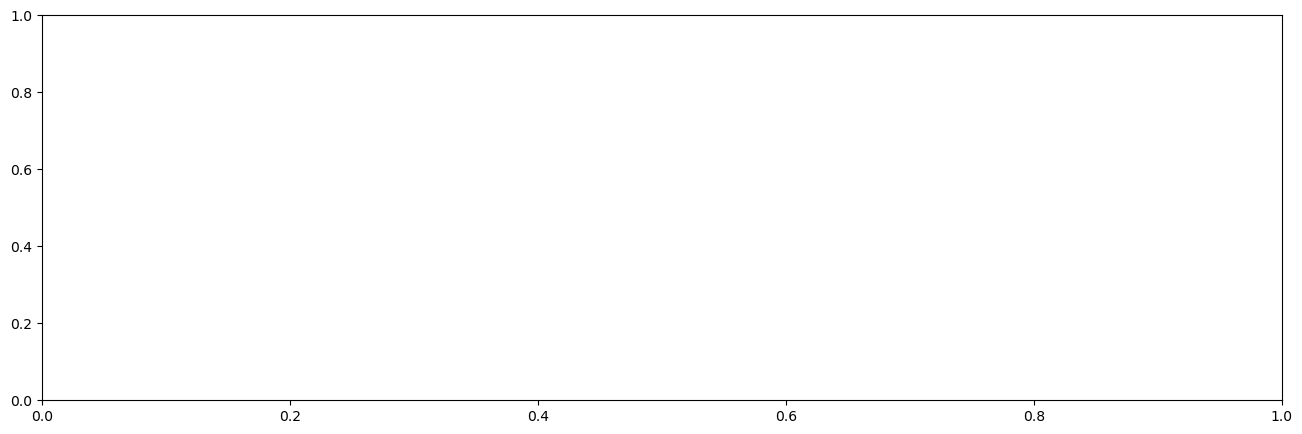

In [16]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(np.arange(1, len(critloss)+1), critloss, c='#00a', alpha=0.75, linewidth=0.75, label='Critic Loss')
ax.plot(np.arange(1, len(actloss)+1), actloss, c='#921', alpha=0.75, linewidth=0.75, label='Actor Loss')
plt.legend()
ax.set_xlabel('Episode #', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.set_title('Reacher Environment solved (30+ avg) with DDPG', fontsize=14)
plt.show()

In [ ]:
### Run some test runs...
for _ in range(1):    
    env_info = env.reset(train_mode=False)[brain_name]        # reset the environment   
    tr_states = env_info.vector_observations                  # get the current state (for each agent)
    tr_scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        tr_actions = agency.act(tr_states, add_noise=False)   # select an action (for each agent)
        env_info = env.step(tr_actions)[brain_name]           # send all actions to tne environment
        tr_next_states = env_info.vector_observations         # get next state (for each agent)
        tr_rewards = env_info.rewards                         # get reward (for each agent)
        tr_dones = env_info.local_done                        # see if episode finished
        tr_scores += env_info.rewards                         # update the score (for each agent)
        tr_states = tr_next_states                            # roll over states to next time step
        if np.any(tr_dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(tr_scores)))

#env.close()

When finished, you can close the environment.

In [ ]:
env.close()

# Evaluation

In [1]:
try: 
    print("Closing the active environment.")
    env.close()
except:
    print("No active environment detected.")

Closing the active environment.
No active environment detected.


In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
import ddpg_agent
from ddpg_agent import * #Agent, normnp, scalenp, SEED, BUFFER_SIZE, BATCH_SIZE, devicez
print("Using device:", device)
%matplotlib inline

Using device: cuda:0


In [2]:
env = UnityEnvironment(file_name='../data/Reacher1_Win/Reacher.exe', worker_id=111, seed=SEED)#, no_graphics=True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33


In [9]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=SEED,
                actor_units_in=512,
                actor_units_hid=128,
                critic_units_in=512,
                critic_units_hid=128,
                actor_filename='../ddpg/checkpoints/actor_training_chkpnt25.pth', 
                critic_filename='../ddpg/checkpoints/critic_training_chkpnt25.pth')

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = 0                                             # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False)       # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    scores += rewards[0]                               # update the score (for each agent)
    dones = env_info.local_done                        # see if episode finished
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 3.609999919310212


In [ ]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=SEED,
                actor_filename='../ddpg/checkpoints/actor_training_chkpnt10.pth', 
                critic_filename='../ddpg/checkpoints/critic_training_chkpnt10.pth')


### WANDB

In [ ]:
import wandb
wandb.login()


# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="reacher v1",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset
    
    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})
    
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

## Iteration 3

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False) # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

## Iteration 4

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=True) # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [ ]:
env.close()